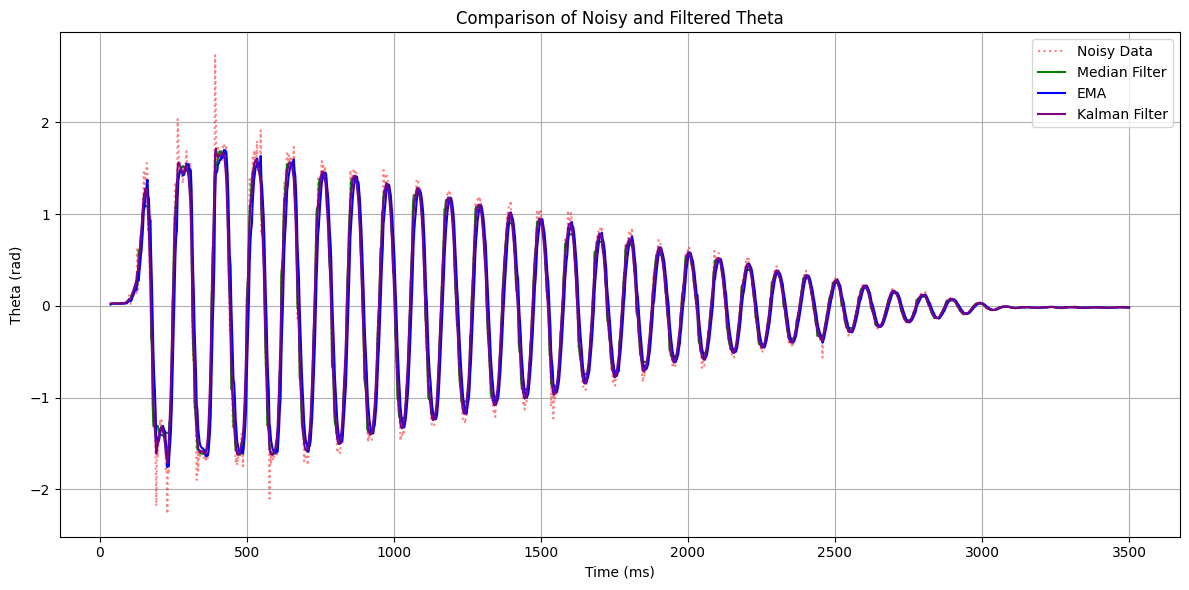

MSE - Median: 0.010436
MSE - EMA: 0.064385
MSE - Kalman: 0.010049


In [1]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Step 1: Load your data
df = pd.read_csv("updated_data.csv")
df['dt'] = df['time'].diff() / 1000.0
df = df.dropna().reset_index(drop=True)

# Step 2: Convert theta to radians
df['theta_rad'] = (df['theta'] / 2048.0) * np.pi

# Step 3: Apply filters
df['theta_med'] = medfilt(df['theta_rad'], kernel_size=15)
df['theta_ema'] = df['theta_rad'].ewm(alpha=0.3, adjust=False).mean()

# Step 4: Advanced Kalman Filter (position + velocity)
dt_mean = df['dt'].mean()

transition_matrix = [[1, dt_mean],
                     [0, 1]]
observation_matrix = [[1, 0]]

kf_advanced = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=[df['theta_rad'].iloc[0], 0],
    transition_covariance=np.diag([3e-3, 3e-3]),  # Q matrix
    observation_covariance=np.array([[0.01]])      # R matrix
)

filtered_state_means, _ = kf_advanced.smooth(df['theta_rad'].values)
df['theta_kalman'] = filtered_state_means[:, 0]
df['theta_dot_kalman'] = filtered_state_means[:, 1]


# Step 5: Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['theta_rad'], label='Noisy Data', color='red', linestyle='dotted', alpha=0.5)
plt.plot(df['time'], df['theta_med'], label='Median Filter', color='green')
plt.plot(df['time'], df['theta_ema'], label='EMA', color='blue')
plt.plot(df['time'], df['theta_kalman'], label='Kalman Filter', color='purple')
plt.xlabel("Time (ms)")
plt.ylabel("Theta (rad)")
plt.title("Comparison of Noisy and Filtered Theta")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Step 6: Metrics
mse_median = mean_squared_error(df['theta_rad'], df['theta_med'])
mse_ema = mean_squared_error(df['theta_rad'], df['theta_ema'])
mse_kalman = mean_squared_error(df['theta_rad'], df['theta_kalman'])

print(f"MSE - Median: {mse_median:.6f}")
print(f"MSE - EMA: {mse_ema:.6f}")
print(f"MSE - Kalman: {mse_kalman:.6f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from Digital_twin import DigitalTwin
from scipy.signal import medfilt
from pykalman import KalmanFilter

# --- Load and process data ---
df = pd.read_csv("updated_data.csv")
df['dt'] = df['time'].diff() / 1000.0
df = df.dropna().reset_index(drop=True)
df['theta_rad'] = (df['theta'] / 2048.0) * np.pi

# Kalman filter
dt_mean = df['dt'].mean()
kf = KalmanFilter(
    transition_matrices=[[1, dt_mean], [0, 1]],
    observation_matrices=[[1, 0]],
    initial_state_mean=[df['theta_rad'].iloc[0], 0],
    transition_covariance=np.diag([3e-3, 3e-3]),
    observation_covariance=np.array([[0.01]])
)
filtered_state_means, _ = kf.smooth(df['theta_rad'].values)
df['theta_kalman'] = filtered_state_means[:, 0]
df['theta_dot_kalman'] = filtered_state_means[:, 1]

# --- Prepare for simulation ---
theta_true = df['theta_kalman'].values
theta_dot_true = df['theta_dot_kalman'].values
n_steps = len(theta_true)
theta_init = theta_true[0]
theta_dot_init = theta_dot_true[0]

# --- Grid search ---
k_range = np.linspace(0.000005, 0.03, 10)
a_m_range = np.linspace(0.00002, 0.8, 10)
M_range = np.linspace(0.5, 2.0, 5)
C_range = np.linspace(0.01, 0.5, 5)

best_params = None
lowest_rmse = float('inf')

for k in k_range:
    for a_m in a_m_range:
        for M in M_range:
            for C in C_range:
                model = DigitalTwin()
                model.k = k
                model.a_m = a_m
                model.M = M
                model.mp = 0.7 * M
                model.mc = 0.3 * M
                model.c_air = C / 2
                model.c_c = C / 2
                model.l = 0.35
                model.R_pulley = 0.01
                model.I = (1 / 3) * model.mp * model.l ** 2

                model.theta = theta_init
                model.theta_dot = theta_dot_init

                simulated_thetas = []
                for _ in range(n_steps):
                    theta, _, _, _ = model.step()
                    simulated_thetas.append(theta)

                rmse = mean_squared_error(theta_true, simulated_thetas)
                if rmse < lowest_rmse:
                    lowest_rmse = rmse
                    best_params = {
                        'k': k,
                        'a_m': a_m,
                        'M': M,
                        'C': C,
                        'RMSE': rmse
                    }

print("✅ Best Parameters Found:")
print(best_params)


pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
Motor data saved to motor_data.csv


2025-04-03 09:50:49.063 python[19637:330465] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-03 09:50:49.063 python[19637:330465] +[IMKInputSession subclass]: chose IMKInputSession_Modern


✅ Best Parameters Found:
{'k': 5e-06, 'a_m': 2e-05, 'M': 1.25, 'C': 0.255, 'RMSE': 0.5249384012447047}


: 